# Importing Libraries

In [1]:
import torch
import torch.nn as nn 
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
import numpy as np

# Declaring Constants

In [2]:
BATCH_SIZE = 64
SHUFFLE = False
EPOCHS = 15

# Setting Compute Engine

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Preparing Dataset

In [4]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_data = torchvision.datasets.MNIST("data", download = True, train = True, transform=transform)
test_data = torchvision.datasets.MNIST("data", download = True, train = False, transform=transform)

train_dataloader = torch.utils.data.DataLoader(train_data, batch_size = BATCH_SIZE, shuffle = SHUFFLE)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle = SHUFFLE)

# Building the Model

In [5]:
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size = 3, padding = 1)
        self.maxpool1 = nn.MaxPool2d(2)
        self.maxpool2 = nn.MaxPool2d(2)
        self.flatten1 = nn.Flatten()
        self.lin1 = nn.Linear(7*7*64, 1024)
        self.lin2 = nn.Linear(1024, 10)
    def forward(self, x):
        x = self.maxpool1(self.conv1(x))
        x = self.maxpool2(self.conv2(x))
        x = F.relu(self.flatten1(x))
        x = F.relu(self.lin1(x))
        x = F.softmax(self.lin2(x))
        return x

# Creating utility functions

In [6]:
def test(model, data, cost_func):
    batches = len(data)
    size = len(data.dataset)
    test_loss = 0
    correct = 0
    model.eval()
    with torch.no_grad():
        for bno, (img, lab) in enumerate(data):
            img, lab = img.to(device), lab.to(device)
            pred = model(img)
            test_loss += cost_func(pred, lab).item()
            correct+= (pred.argmax(1)==lab).type(torch.float).sum().item()
    test_loss /= batches
    correct /= size
    print("Test Performance :\n\tAccuracy: %f\tLoss: %f"%(100*correct, test_loss))
    return 100*correct, test_loss

In [7]:
def train(model, data, cost_func, optim, tdata):
    import time
    history = {
        "train_accuracy":[],
        "test_accuracy":[],
        "train_loss":[],
        "test_loss":[],
        "time":[]
    }
    batches = len(data)
    size = len(data.dataset)
    for i in range(EPOCHS):
        t1 = time.time()
        tacc = 0
        tloss = 0
        print("EPOCH [%d/%d]\n---------------"%(i+1, EPOCHS))
        for bno, (img, lab) in enumerate(data):
            img, lab = img.to(device), lab.to(device)
            outs = model(img)
            loss = cost_func(outs, lab)

            optim.zero_grad()
            loss.backward()
            optim.step()

            tacc += (outs.argmax(1) == lab).type(torch.float).sum().item()/BATCH_SIZE
            tloss += loss.item()
            if bno%100 ==0:
                print("Accuracy: %f\tLoss: %f\t[%5d/%d]"%((outs.argmax(1) == lab).type(torch.float).sum().item()*100/BATCH_SIZE, loss.item(), (bno+1)*size/batches, size))
        print("Train Performance :\n\tAccuracy: %f\tLoss: %f"%(tacc*100/batches, tloss/batches))
        test_acc, test_loss = test(model, tdata, cost_func)
        history["time"].append(time.time()-t1)
        history["train_accuracy"].append(tacc*100/batches)
        history["train_loss"].append(tloss/batches)
        history["test_accuracy"].append(test_acc)
        history["test_loss"].append(test_loss)
        print("Time taken : %f s\n"%(history["time"][-1]))
    return history

# Model Training

## Initialization of model object

In [8]:
model = CNN().to(device)
print(model)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten1): Flatten(start_dim=1, end_dim=-1)
  (lin1): Linear(in_features=3136, out_features=1024, bias=True)
  (lin2): Linear(in_features=1024, out_features=10, bias=True)
)


## Fixing evaluation and update metrics

In [9]:
cost_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

## Training Loop

In [10]:
history = train(model, train_dataloader, cost_fn, optimizer, test_dataloader)

EPOCH [1/15]
---------------
<ipython-input-5-99d6d1bf4d0a>:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.lin2(x))
Accuracy: 12.500000	Loss: 2.302972	[   63/60000]
Accuracy: 75.000000	Loss: 1.708807	[ 6460/60000]
Accuracy: 90.625000	Loss: 1.564944	[12857/60000]
Accuracy: 95.312500	Loss: 1.513231	[19253/60000]
Accuracy: 96.875000	Loss: 1.502650	[25650/60000]
Accuracy: 95.312500	Loss: 1.511487	[32046/60000]
Accuracy: 98.437500	Loss: 1.479211	[38443/60000]
Accuracy: 93.750000	Loss: 1.520635	[44840/60000]
Accuracy: 93.750000	Loss: 1.517500	[51236/60000]
Accuracy: 92.187500	Loss: 1.532135	[57633/60000]
Train Performance :
	Accuracy: 90.411780	Loss: 1.558901
Test Performance :
	Accuracy: 96.920000	Loss: 1.492001
Time taken : 7.785206 s

EPOCH [2/15]
---------------
Accuracy: 96.875000	Loss: 1.491074	[   63/60000]
Accuracy: 96.875000	Loss: 1.485598	[ 6460/60000]
Accuracy: 98.437500	Loss: 1.4765

## Performance Visualization

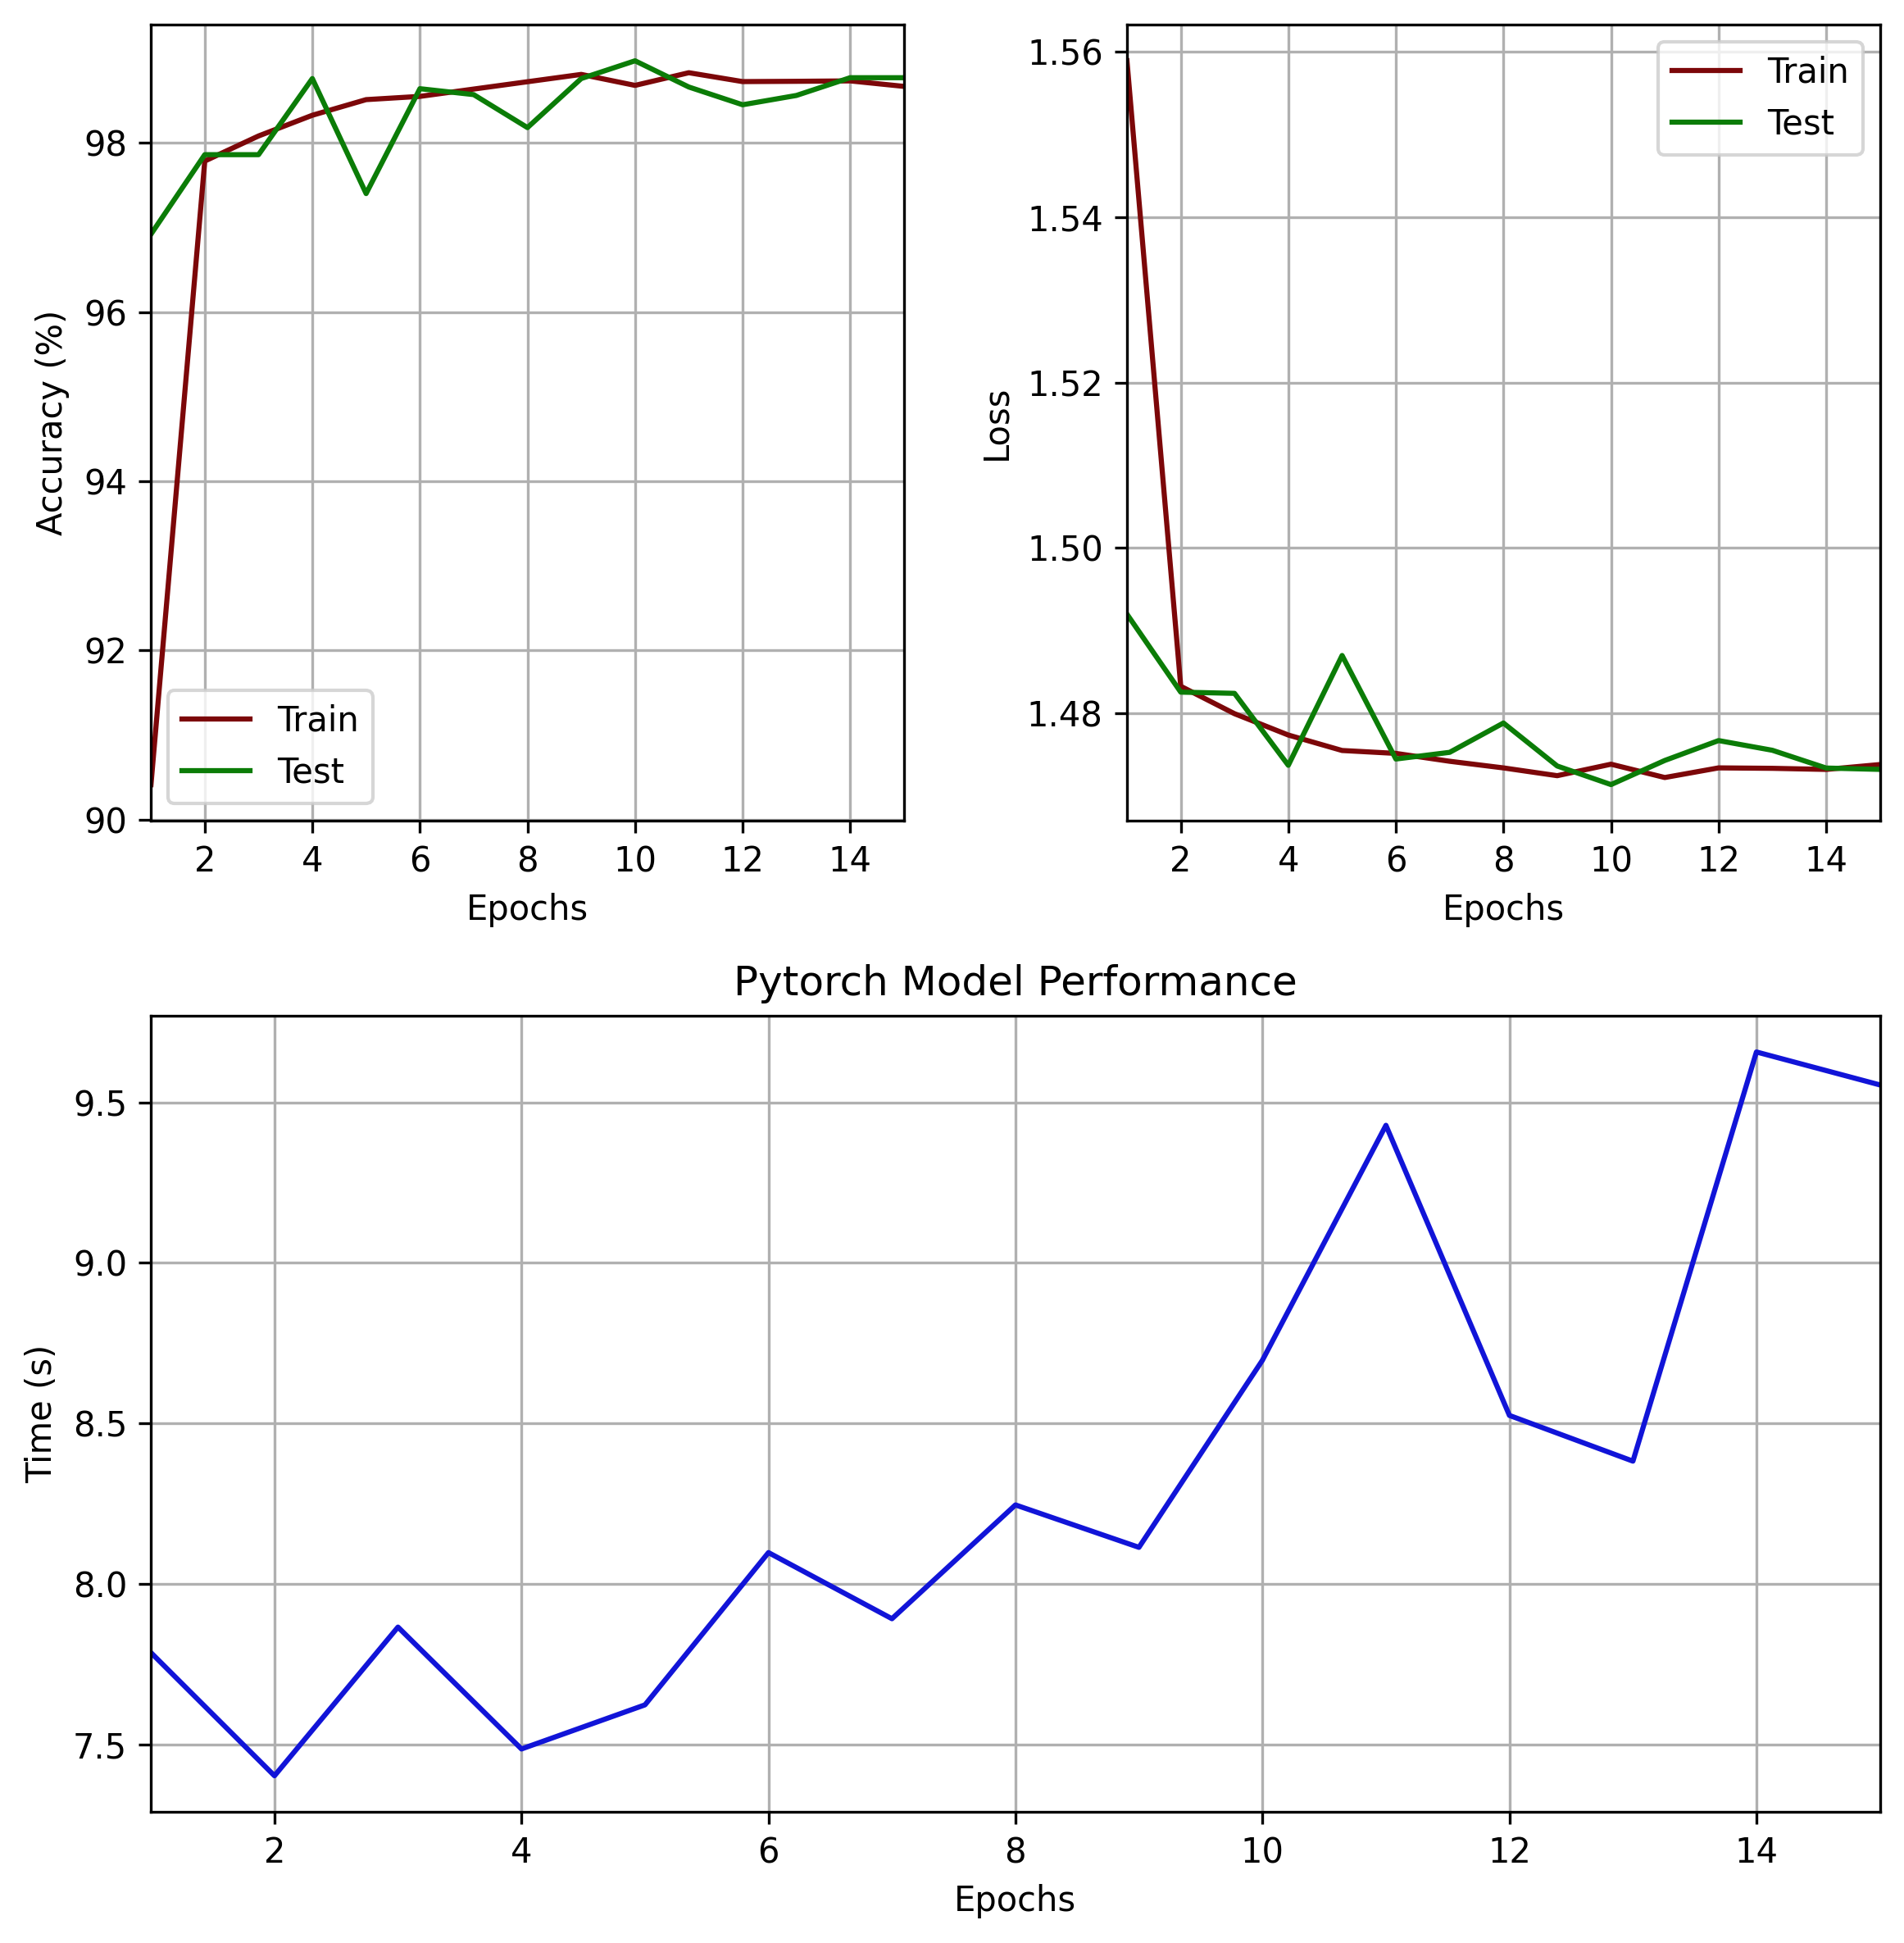

In [11]:
fig = plt.figure(figsize=(8, 8), dpi=300)

ax = fig.add_subplot(221)
ax.plot(np.arange(len(history["time"]))+1, history["train_accuracy"], label = "Train", color="#7c0709")
ax.plot(np.arange(len(history["time"]))+1, history["test_accuracy"], label = "Test", color="#0b7c07")
ax.set_ylabel("Accuracy (%)")
ax.set_xlabel("Epochs")
ax.set_xlim(1, len(history["time"]))
ax.legend()
ax.grid(True)

ax = fig.add_subplot(222)
ax.plot(np.arange(len(history["time"]))+1, history["train_loss"], label = "Train", color="#7c0709")
ax.plot(np.arange(len(history["time"]))+1, history["test_loss"], label = "Test", color="#0b7c07")
ax.set_ylabel("Loss")
ax.set_xlabel("Epochs")
ax.set_xlim(1, len(history["time"]))
ax.legend()
ax.grid(True)

ax = fig.add_subplot(212)
ax.plot(np.arange(len(history["time"]))+1, history["time"], color="#1114d8")
ax.set_ylabel("Time (s)")
ax.set_xlabel("Epochs")
ax.set_xlim(1, len(history["time"]))
ax.grid(True)

plt.title("Pytorch Model Performance")
plt.tight_layout()
plt.savefig("resources/torch_perf.png", dpi=300)
plt.savefig("resources/torch_perf.pdf", dpi=300)
plt.show()